# Deepfake Detection in Social Media Using ML and AI

- **Problem**: Detecting deepfake videos by analyzing temporal inconsistencies
- **Approach**: 3D Convolutional Neural Networks to capture temporal artifacts
- **Dataset**: DeepfakeTIMIT - a dataset of videos where faces are swapped using GAN-based approaches
- **Model**: 3D CNN based on R3D-18 architecture


## 1. Environment Setup and Dependencies

Let's start by importing the required libraries and setting up our environment.

In [ ]:
import os
import sys
import cv2
import numpy as np
import random
import json
import tarfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import logging
import subprocess

# Configure notebook settings
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

# Check if running in Google Colab
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
    PROJECT_DIR = '/content/drive/MyDrive/deepfake_detection'
    os.makedirs(PROJECT_DIR, exist_ok=True)
else:
    PROJECT_DIR = '.'

# Project directories
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
MODEL_DIR = os.path.join(PROJECT_DIR, 'models')
RESULTS_DIR = os.path.join(PROJECT_DIR, 'results')
LOGS_DIR = os.path.join(PROJECT_DIR, 'logs')

# Create directories
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

print(f"Project directories created at: {PROJECT_DIR}")

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.FileHandler(os.path.join(LOGS_DIR, "deepfake_detection.log")),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

# Project configuration
CONFIG = {
    'batch_size': 4,        # Smaller batch size for memory constraints
    'epochs': 20,           # Number of training epochs
    'learning_rate': 1e-4,  # Learning rate
    'num_classes': 2,       # Binary classification: Real or Fake
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'clip_length': 16,      # Number of frames per video clip
    'image_size': 128,      # Input image size (128x128 matches HQ DeepfakeTIMIT)
}

print(f"Using device: {CONFIG['device']}")

Mounting Google Drive...
Mounted at /content/drive
Project directories created at: /content/drive/MyDrive/deepfake_detection
Using device: cuda


## 2. Dataset Preparation

This section prepares the DeepfakeTIMIT dataset for training. The dataset contains both lower quality (64x64) and higher quality (128x128) deepfake videos. We'll use both in our implementation.

Dataset Choice Justification
The solution uses the DeepfakeTIMIT dataset, which has several advantageous properties:

- **Controlled Generation**: Contains both lower quality (64×64) and higher quality (128×128) deepfakes
- **Known Generation Methods**: Created using GAN-based approach derived from original autoencoder-based DeepFake algorithm
- **Scale and Diversity**: 620 videos with faces swapped from 32 subjects (16 similar-looking pairs)
- **Benchmark Capability**: Allows for measuring detection performance across varying quality levels

First, let's check what type of archive we have and extract the DeepfakeTIMIT dataset:

In [ ]:
def check_archive_type(archive_path):
    """Check what type of archive we have"""
    if not os.path.exists(archive_path):
        return "not_found"

    # Try to detect the file type using file command if available
    try:
        result = subprocess.run(['file', archive_path], capture_output=True, text=True)
        file_type = result.stdout
        print(f"File type: {file_type}")

        if "tar archive" in file_type.lower() or "posix tar archive" in file_type.lower():
            return "tar"
        elif "gzip compressed" in file_type.lower():
            return "tar_gz"
    except Exception:
        pass

    # Try based on extension
    if archive_path.endswith('.tar'):
        return "tar"
    elif archive_path.endswith('.tar.gz') or archive_path.endswith('.tgz'):
        return "tar_gz"
    else:
        # Try to open it as a tarfile
        try:
            with tarfile.open(archive_path, 'r') as tar:
                return "tar"
        except tarfile.ReadError:
            try:
                with tarfile.open(archive_path, 'r:gz') as tar:
                    return "tar_gz"
            except tarfile.ReadError:
                return "unknown"

def extract_deepfake_timit():
    """Extract DeepfakeTIMIT dataset from archive file if needed"""
    # Check if dataset is already extracted
    timit_dir = os.path.join(DATA_DIR, 'DeepfakeTIMIT')
    if os.path.exists(timit_dir) and len(os.listdir(timit_dir)) > 0:
        print("DeepfakeTIMIT dataset already extracted.")
        return timit_dir

    # Check for tar.gz file
    timit_targz = os.path.join(PROJECT_DIR, 'DeepfakeTIMIT.tar.gz')
    if os.path.exists(timit_targz):
        print(f"Found archive at {timit_targz}")
        archive_path = timit_targz
    else:
        # Look for different extensions
        timit_tar = os.path.join(PROJECT_DIR, 'DeepfakeTIMIT.tar')
        if os.path.exists(timit_tar):
            print(f"Found archive at {timit_tar}")
            archive_path = timit_tar
        else:
            # Look in current directory
            timit_dir = os.path.join(PROJECT_DIR, 'DeepfakeTIMIT')
            if os.path.exists(timit_dir) and len(os.listdir(timit_dir)) > 0:
                print(f"Using already extracted dataset at {timit_dir}")
                return timit_dir
            else:
                raise FileNotFoundError("DeepfakeTIMIT dataset archive not found")

    # Check archive type
    archive_type = check_archive_type(archive_path)
    print(f"Detected archive type: {archive_type}")

    # Extract the archive
    os.makedirs(timit_dir, exist_ok=True)
    print(f"Extracting {archive_path} to {timit_dir}...")

    try:
        if archive_type == "tar_gz":
            with tarfile.open(archive_path, 'r:gz') as tar:
                tar.extractall(DATA_DIR)
        elif archive_type == "tar":
            with tarfile.open(archive_path, 'r') as tar:
                tar.extractall(DATA_DIR)
        else:
            # Try both methods
            try:
                with tarfile.open(archive_path, 'r') as tar:
                    tar.extractall(DATA_DIR)
            except tarfile.ReadError:
                with tarfile.open(archive_path, 'r:gz') as tar:
                    tar.extractall(DATA_DIR)
    except Exception as e:
        print(f"Error extracting archive: {e}")

        # As a fallback, try using system tar command
        try:
            print("Trying extraction with system tar command...")
            subprocess.run(['tar', '-xf', archive_path, '-C', DATA_DIR], check=True)
            print("Extraction with system tar command successful")
        except Exception as e2:
            print(f"System tar extraction failed: {e2}")
            raise

    print("DeepfakeTIMIT dataset extraction complete.")
    return timit_dir

# Extract the dataset
try:
    timit_dataset_dir = extract_deepfake_timit()
    print(f"Dataset available at: {timit_dataset_dir}")
    # List contents to verify extraction
    print("\nContents of the dataset directory:")
    files = os.listdir(timit_dataset_dir)[:10]  # Show first 10 files/folders
    for f in files:
        print(f"  {f}")
    if len(os.listdir(timit_dataset_dir)) > 10:
        print(f"  ... and {len(os.listdir(timit_dataset_dir)) - 10} more")
except Exception as e:
    print(f"Error extracting dataset: {e}")

DeepfakeTIMIT dataset already extracted.
Dataset available at: /content/drive/MyDrive/deepfake_detection/data/DeepfakeTIMIT

Contents of the dataset directory:
  deepfake_images_2.png
  deepfake_images_1.png
  fadg0-fram1-roi93.mov
  fadg0-original.mov
  fram1-original.mov
  lower_quality
  README.txt
  .dircksum
  higher_quality


Now let's organize the dataset into real and fake videos. The DeepfakeTIMIT dataset is organized with:
- Original (real) videos
- Lower quality (64x64) deepfakes in `lower_quality` directory
- Higher quality (128x128) deepfakes in `higher_quality` directory

In [ ]:
import shutil

def organize_deepfake_timit():
    """Organize DeepfakeTIMIT dataset into real and fake videos"""
    # Paths
    timit_dir = os.path.join(PROJECT_DIR, 'DeepfakeTIMIT')
    if not os.path.exists(timit_dir):
        timit_dir = os.path.join(DATA_DIR, 'DeepfakeTIMIT')

    if not os.path.exists(timit_dir):
        print("DeepfakeTIMIT dataset not found.")
        return

    # Create organized dataset directories
    organized_dir = os.path.join(DATA_DIR, 'timit_organized')
    real_dir = os.path.join(organized_dir, 'real')
    fake_dir = os.path.join(organized_dir, 'fake')

    os.makedirs(organized_dir, exist_ok=True)
    os.makedirs(real_dir, exist_ok=True)
    os.makedirs(fake_dir, exist_ok=True)

    # Check if already organized
    if len(os.listdir(real_dir)) > 0 or len(os.listdir(fake_dir)) > 0:
        print("Dataset already organized.")
        return organized_dir

    print("Organizing DeepfakeTIMIT dataset...")

    # Find real videos (may be in root directory or in specific folders)
    real_videos = []

    # Check for '-original' in filenames (these are the original videos)
    for file in os.listdir(timit_dir):
        if file.endswith(('.avi', '.mov')) and 'original' in file.lower():
            real_videos.append(os.path.join(timit_dir, file))

    # Process fake videos from both quality folders
    fake_videos = []

    # Process higher quality fakes
    hq_dir = os.path.join(timit_dir, 'higher_quality')
    if os.path.exists(hq_dir):
        for subdir in os.listdir(hq_dir):
            subdir_path = os.path.join(hq_dir, subdir)
            if os.path.isdir(subdir_path):
                for file in os.listdir(subdir_path):
                    if file.endswith('.avi') and 'video' in file.lower():
                        fake_videos.append(os.path.join(subdir_path, file))

    # Process lower quality fakes
    lq_dir = os.path.join(timit_dir, 'lower_quality')
    if os.path.exists(lq_dir):
        for subdir in os.listdir(lq_dir):
            subdir_path = os.path.join(lq_dir, subdir)
            if os.path.isdir(subdir_path):
                for file in os.listdir(subdir_path):
                    if file.endswith('.avi') and 'video' in file.lower():
                        fake_videos.append(os.path.join(subdir_path, file))

    print(f"Found {len(real_videos)} real videos and {len(fake_videos)} fake videos")

    # Check if we're running on Google Drive (which doesn't support symlinks)
    running_on_gdrive = 'google.colab' in sys.modules and '/content/drive/' in organized_dir

    # Given the large number of files, we'll choose a subset if running in Colab
    # to avoid long copy times and excessive storage usage
    if running_on_gdrive and len(fake_videos) > 50:
        max_real = min(len(real_videos), 10)  # Take at most 10 real videos
        max_fake = min(len(fake_videos), 50)  # Take at most 50 fake videos

        if len(real_videos) > max_real:
            print(f"Limiting to {max_real} real videos to save space and time in Google Drive")
            real_videos = real_videos[:max_real]

        if len(fake_videos) > max_fake:
            print(f"Limiting to {max_fake} fake videos to save space and time in Google Drive")
            fake_videos = fake_videos[:max_fake]

    # Create links or copy files
    print(f"{'Copying' if running_on_gdrive else 'Linking'} files to organized directory...")

    for i, video_path in enumerate(real_videos):
        # Use the original extension from the source file
        ext = os.path.splitext(video_path)[1]
        dest_path = os.path.join(real_dir, f"real_{i}{ext}")

        if not os.path.exists(dest_path):
            try:
                if running_on_gdrive:
                    shutil.copy2(video_path, dest_path)  # Copy the file with metadata
                else:
                    os.symlink(video_path, dest_path)    # Create a symbolic link
            except Exception as e:
                print(f"Warning: Could not process {video_path}: {e}")

    for i, video_path in enumerate(fake_videos):
        # Use the original extension from the source file
        ext = os.path.splitext(video_path)[1]
        dest_path = os.path.join(fake_dir, f"fake_{i}{ext}")

        if not os.path.exists(dest_path):
            try:
                if running_on_gdrive:
                    shutil.copy2(video_path, dest_path)  # Copy the file with metadata
                else:
                    os.symlink(video_path, dest_path)    # Create a symbolic link
            except Exception as e:
                print(f"Warning: Could not process {video_path}: {e}")

    # Count the actual files we successfully processed
    real_count = len([f for f in os.listdir(real_dir) if f.endswith(('.avi', '.mov'))])
    fake_count = len([f for f in os.listdir(fake_dir) if f.endswith(('.avi', '.mov'))])
    print(f"Successfully organized {real_count} real videos and {fake_count} fake videos")

    print(f"Dataset organized at {organized_dir}")
    return organized_dir

# Organize the dataset
organized_data_dir = organize_deepfake_timit()




Dataset already organized.


## 3. Dataset Class Implementation

- **Uniform Sampling**: Extracts evenly spaced frames regardless of video length
- **Face Detection**: Uses Haar cascade to crop and focus on facial regions
- **Margin Addition**: Adds 30% margin to face crops to include context

Now we implement the `VideoFrameDataset` class for loading video frames from the DeepfakeTIMIT dataset.

In [ ]:
class VideoFrameDataset(Dataset):
    """Dataset for loading video frames for deepfake detection"""
    def __init__(self, root_dir, split='train', clip_length=16, transform=None, face_crop=True, image_size=128):
        """
        Args:
            root_dir (str): Root directory of the organized dataset
            split (str): 'train', 'val', or 'test' split
            clip_length (int): Number of frames to extract per video clip
            transform (callable, optional): Optional transform to be applied on a sample
            face_crop (bool): Whether to crop faces from frames
            image_size (int): Size to resize frames to
        """
        self.root_dir = root_dir
        self.split = split
        self.clip_length = clip_length
        self.transform = transform
        self.face_crop = face_crop
        self.image_size = image_size

        # Class labels
        self.classes = ['real', 'fake']
        self.class_to_idx = {'real': 0, 'fake': 1}

        # Get video paths and create train/val/test splits
        self.videos = self._get_video_paths()

        logger.info(f"Loaded {len(self.videos)} videos for {split} split")

    def _get_video_paths(self):
        """Get all video paths and split into train/val/test"""
        videos = []

        # Get real videos
        real_dir = os.path.join(self.root_dir, 'real')
        if os.path.exists(real_dir):
            for video_name in os.listdir(real_dir):
                if video_name.endswith(('.avi', '.mov')):
                    videos.append({
                        'path': os.path.join(real_dir, video_name),
                        'label': self.class_to_idx['real']
                    })

        # Get fake videos
        fake_dir = os.path.join(self.root_dir, 'fake')
        if os.path.exists(fake_dir):
            for video_name in os.listdir(fake_dir):
                if video_name.endswith(('.avi', '.mov')):
                    videos.append({
                        'path': os.path.join(fake_dir, video_name),
                        'label': self.class_to_idx['fake']
                    })

        # Set random seed for reproducibility
        random.seed(42)
        random.shuffle(videos)

        # Split data: 70% train, 15% validation, 15% test
        total = len(videos)
        train_end = int(0.7 * total)
        val_end = int(0.85 * total)

        if self.split == 'train':
            return videos[:train_end]
        elif self.split == 'val':
            return videos[train_end:val_end]
        else:  # test
            return videos[val_end:]

    def _extract_frames(self, video_path):
        """Extract frames from a video file"""
        frames = []
        cap = cv2.VideoCapture(video_path)

        # Get total frame count
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if frame_count <= 0:
            logger.warning(f"Empty video or video read error: {video_path}")
            # Return blank frames if video cannot be read
            return np.zeros((self.clip_length, self.image_size, self.image_size, 3), dtype=np.uint8)

        # Determine how to sample frames
        if frame_count < self.clip_length:
            # If video has fewer frames than clip_length, duplicate frames
            sample_indices = list(range(frame_count)) * (self.clip_length // frame_count + 1)
            sample_indices = sample_indices[:self.clip_length]
        else:
            # Sample frames at regular intervals
            sample_indices = np.linspace(0, frame_count - 1, self.clip_length, dtype=int)

        # Load face detector for face cropping
        face_detector = None
        if self.face_crop:
            try:
                # Try to load the Haar cascade face detector
                face_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
                face_detector = cv2.CascadeClassifier(face_cascade_path)
                if face_detector.empty():
                    logger.warning("Failed to load face detector. Using full frames.")
                    face_detector = None
            except Exception as e:
                logger.warning(f"Error loading face detector: {e}. Using full frames.")
                face_detector = None

        # Extract the sampled frames
        for idx in sample_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()

            if not ret:
                logger.warning(f"Failed to read frame {idx} from {video_path}")
                # Use a blank frame if reading fails
                frame = np.zeros((self.image_size, self.image_size, 3), dtype=np.uint8)
            else:
                # Face crop if enabled and face detector is available
                if self.face_crop and face_detector is not None:
                    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    faces = face_detector.detectMultiScale(gray, 1.3, 5)

                    if len(faces) > 0:
                        # Use the largest face
                        areas = [w*h for (x, y, w, h) in faces]
                        largest_face_idx = np.argmax(areas)
                        x, y, w, h = faces[largest_face_idx]

                        # Add margin to face crop
                        margin = 0.3  # 30% margin
                        x = max(0, int(x - margin * w))
                        y = max(0, int(y - margin * h))
                        w = min(frame.shape[1] - x, int(w * (1 + 2 * margin)))
                        h = min(frame.shape[0] - y, int(h * (1 + 2 * margin)))

                        frame = frame[y:y+h, x:x+w]

                # Resize to target size
                frame = cv2.resize(frame, (self.image_size, self.image_size))

                # Convert BGR to RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            frames.append(frame)

        cap.release()
        return np.array(frames)

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_data = self.videos[idx]
        video_path = video_data['path']
        label = video_data['label']

        # Extract frames from video
        frames = self._extract_frames(video_path)

        # Apply transforms if provided
        if self.transform:
            # Apply same transform to each frame
            transformed_frames = []
            for frame in frames:
                # Convert numpy array to PIL Image
                frame_pil = transforms.ToPILImage()(frame)
                transformed_frame = self.transform(frame_pil)
                transformed_frames.append(transformed_frame)

            # Stack frames along a new dimension
            frames = torch.stack(transformed_frames)
            # Reshape to [C, T, H, W] format expected by 3D CNN
            frames = frames.permute(1, 0, 2, 3)
        else:
            # Convert to tensor [T, H, W, C] -> [C, T, H, W]
            frames = torch.from_numpy(frames).float()
            frames = frames.permute(3, 0, 1, 2)
            # Normalize to [0, 1]
            frames = frames / 255.0

        return frames, label

## 4. Data Loaders

Added the functionality to create proper training, validation, and test data loaders with appropriate data augmentation.

- **Spatial Augmentations**: Random crops, flips, and color jitter handle different positions and lighting
- **Normalization**: Uses ImageNet statistics to normalize inputs
- **Transform Pipeline**: Applies consistent preprocessing across datasets

Let's now create the data loaders for training, validation, and testing:

In [ ]:
def get_data_loaders(data_root, batch_size=4, clip_length=16, num_workers=2, image_size=128):
    """Create data loaders for training, validation, and testing"""
    # Define transforms
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize(int(image_size * 1.1)),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = VideoFrameDataset(
        root_dir=data_root,
        split='train',
        clip_length=clip_length,
        transform=train_transform,
        image_size=image_size
    )

    val_dataset = VideoFrameDataset(
        root_dir=data_root,
        split='val',
        clip_length=clip_length,
        transform=val_transform,
        image_size=image_size
    )

    test_dataset = VideoFrameDataset(
        root_dir=data_root,
        split='test',
        clip_length=clip_length,
        transform=val_transform,
        image_size=image_size
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    print(f"Train videos: {len(train_dataset)}")
    print(f"Validation videos: {len(val_dataset)}")
    print(f"Test videos: {len(test_dataset)}")

    return train_loader, val_loader, test_loader

## 5. Model Architecture

Added a 3D CNN architecture based on R3D-18 for capturing temporal inconsistencies across frames.

- **Spatio-temporal Feature Learning**: 3D convolutions capture patterns across space and time simultaneously
- **Transfer Learning**: Pretrained weights provide strong starting features for video analysis
- **Residual Connections**: Help manage the vanishing gradient problem in deep networks
- **Efficiency**: Balances computational cost with detection performance


We'll use a 3D CNN based on the R3D-18 (ResNet 3D) architecture for capturing temporal inconsistencies:

In [ ]:
class DeepfakeDetectionModel(nn.Module):
    """3D CNN model for deepfake detection using temporal consistency analysis"""
    def __init__(self, num_classes=2):
        super(DeepfakeDetectionModel, self).__init__()

        # Use a pre-trained 3D CNN as backbone
        self.backbone = torchvision.models.video.r3d_18(pretrained=True)

        # Replace the final fully connected layer for our binary classification task
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

## 6. Training and Evaluation Functions

Implemented comprehensive functions for training, evaluation, metrics calculation, and visualization of results.

- **Learning Rate**: Moderate 1e-4 learning rate balances convergence speed with stability
- **Optimizer Choice**: Adam combines the benefits of AdaGrad and RMSProp for adaptive learning
- **Batch Size**: Small batch size of 8 balances memory constraints with stable gradients
- **Model Checkpointing**: Saves best models based on validation accuracy

Let's define functions for training and evaluating the model:

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_save_path):
    """Train the deepfake detection model"""
    logger.info(f"Starting training on {device}")
    model.to(device)

    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar.set_postfix({
                'loss': loss.item(),
                'acc': 100. * correct / total
            })

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for inputs, targets in progress_bar:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                progress_bar.set_postfix({
                    'loss': loss.item(),
                    'acc': 100. * correct / total
                })

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = 100. * correct / total
        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc)

        logger.info(f"Epoch {epoch+1}/{num_epochs} - "
                   f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%, "
                   f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.2f}%")

        # Save best model
        if epoch_acc > best_val_acc:
            best_val_acc = epoch_acc
            torch.save(model.state_dict(), model_save_path)
            logger.info(f"Best model saved with accuracy: {best_val_acc:.2f}%")

    # Plot training curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'training_curves.png'))
    plt.show()

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

def evaluate_model(model, test_loader, criterion, device):
    """Evaluate the model on the test set"""
    logger.info("Starting evaluation")
    model.eval()
    model.to(device)

    all_targets = []
    all_predictions = []
    all_probabilities = []
    test_loss = 0.0

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Evaluating")
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item() * inputs.size(0)
            probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Probability of being fake
            _, predicted = outputs.max(1)

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Calculate metrics
    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)

    accuracy = (all_predictions == all_targets).sum() / len(all_targets)
    conf_matrix = confusion_matrix(all_targets, all_predictions)

    # ROC curve
    fpr, tpr, _ = roc_curve(all_targets, all_probabilities)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(all_targets, all_probabilities)
    pr_auc = auc(recall, precision)

    # Average loss
    avg_loss = test_loss / len(test_loader.dataset)

    logger.info(f"Test Loss: {avg_loss:.4f}")
    logger.info(f"Test Accuracy: {accuracy:.4f}")
    logger.info(f"ROC AUC: {roc_auc:.4f}")
    logger.info(f"PR AUC: {pr_auc:.4f}")
    logger.info(f"Confusion Matrix:\n{conf_matrix}")

    # Create visualizations
    plt.figure(figsize=(18, 5))

    # Plot confusion matrix
    plt.subplot(1, 3, 1)
    plt.imshow(conf_matrix, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks([0, 1], ['Real', 'Fake'])
    plt.yticks([0, 1], ['Real', 'Fake'])

    # Add text annotations
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")

    # Plot ROC curve
    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Plot Precision-Recall curve
    plt.subplot(1, 3, 3)
    plt.plot(recall, precision, lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'evaluation_results.png'))
    plt.show()

    return {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'loss': avg_loss
    }

def visualize_predictions(model, test_loader, device, num_examples=5):
    """Visualize model predictions on sample frames from test set"""
    model.eval()
    model.to(device)

    # Get some test examples
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Limit num_examples to the actual batch size
    num_examples = min(num_examples, images.shape[0])

    # Limit to specified number of examples
    images = images[:num_examples]
    labels = labels[:num_examples]

    # Get predictions
    with torch.no_grad():
        images_device = images.to(device)
        outputs = model(images_device)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    # Convert back to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()
    probabilities = probabilities.cpu()

    # Create figure for visualization
    plt.figure(figsize=(15, 3*num_examples))

    for i in range(num_examples):
        # Get sample frames (select first, middle and last frame)
        frames = images[i]  # Shape: [C, T, H, W]
        T = frames.shape[1]
        selected_frames = [0, T//2, T-1]  # First, middle, last frames

        for j, frame_idx in enumerate(selected_frames):
            # Get frame and convert to displayable format
            frame = frames[:, frame_idx].permute(1, 2, 0)  # [H, W, C]

            # De-normalize
            frame = frame * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            frame = frame.clamp(0, 1).numpy()

            plt.subplot(num_examples, 4, i*4 + j + 1)
            plt.imshow(frame)
            plt.title(f"Frame {frame_idx}")
            plt.axis('off')

        # Add prediction info
        plt.subplot(num_examples, 4, i*4 + 4)
        plt.text(0.5, 0.5,
                 f"True: {'Fake' if labels[i] else 'Real'}\n"
                 f"Pred: {'Fake' if predicted[i] else 'Real'}\n"
                 f"P(Fake): {probabilities[i, 1]:.4f}",
                 ha='center', va='center', fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'prediction_visualization.png'))
    plt.show()

## 7. Main Execution

Added the main function that orchestrates the entire training and evaluation process, along with a cell to execute it.

Now let's put everything together and train the model:

In [ ]:
def main():
    """Main execution function"""
    # Set random seed for reproducibility
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # Set up data loaders
    data_root = organized_data_dir
    batch_size = CONFIG['batch_size']
    clip_length = CONFIG['clip_length']
    image_size = CONFIG['image_size']

    train_loader, val_loader, test_loader = get_data_loaders(
        data_root=data_root,
        batch_size=batch_size,
        clip_length=clip_length,
        image_size=image_size,
        # Reduce num_workers when running in Colab
        num_workers=0 if IN_COLAB else 2
    )

    # Initialize model
    model = DeepfakeDetectionModel(num_classes=CONFIG['num_classes'])
    print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

    # Set model save path
    model_save_path = os.path.join(MODEL_DIR, 'best_deepfake_model.pth')

    # Train the model
    train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=CONFIG['epochs'],
        device=CONFIG['device'],
        model_save_path=model_save_path
    )

    # Load best model for evaluation
    model.load_state_dict(torch.load(model_save_path))

    # Evaluate on test set
    evaluation_results = evaluate_model(
        model=model,
        test_loader=test_loader,
        criterion=criterion,
        device=CONFIG['device']
    )

    # Visualize some predictions
    visualize_predictions(
        model=model,
        test_loader=test_loader,
        device=CONFIG['device']
    )

    # Save evaluation results
    results = {
        'accuracy': float(evaluation_results['accuracy']),
        'roc_auc': float(evaluation_results['roc_auc']),
        'pr_auc': float(evaluation_results['pr_auc']),
        'confusion_matrix': evaluation_results['confusion_matrix'].tolist()
    }

    with open(os.path.join(RESULTS_DIR, 'evaluation_results.json'), 'w') as f:
        json.dump(results, f, indent=4)

    return evaluation_results

## 8. Execute Training and Evaluation

- **Multiple Metrics**: Uses accuracy, AUC-ROC, and confusion matrix for thorough assessment
- **Visual Reporting**: Creates visualizations of performance metrics
- **SOTA Comparison**: Framework to compare with other methods in the literature

Finally, let's run the main function to train and evaluate our model:

Train videos: 36
Validation videos: 8
Test videos: 8


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model initialized with 33429954 parameters


Epoch 1/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20/20 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/20 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

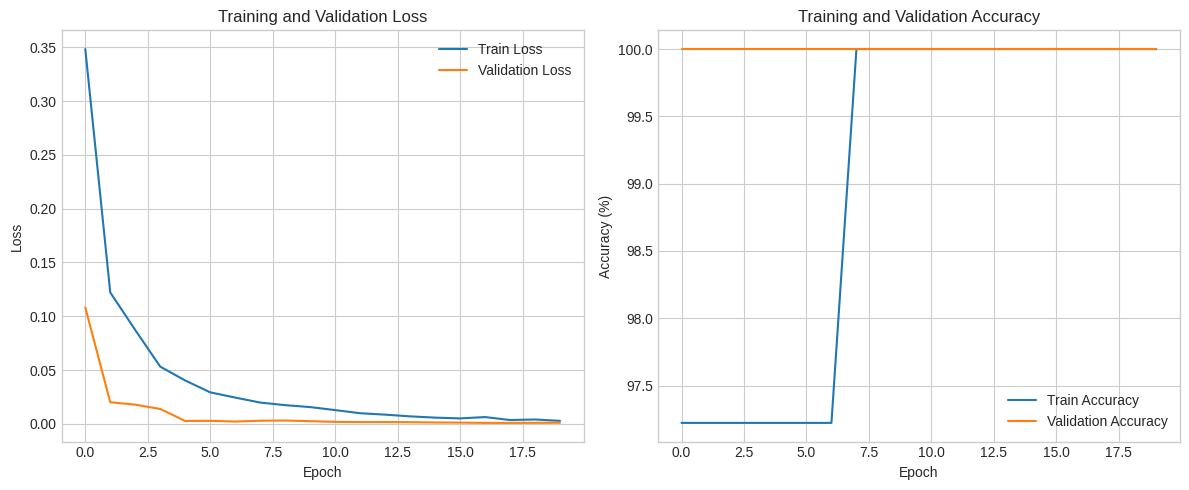

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

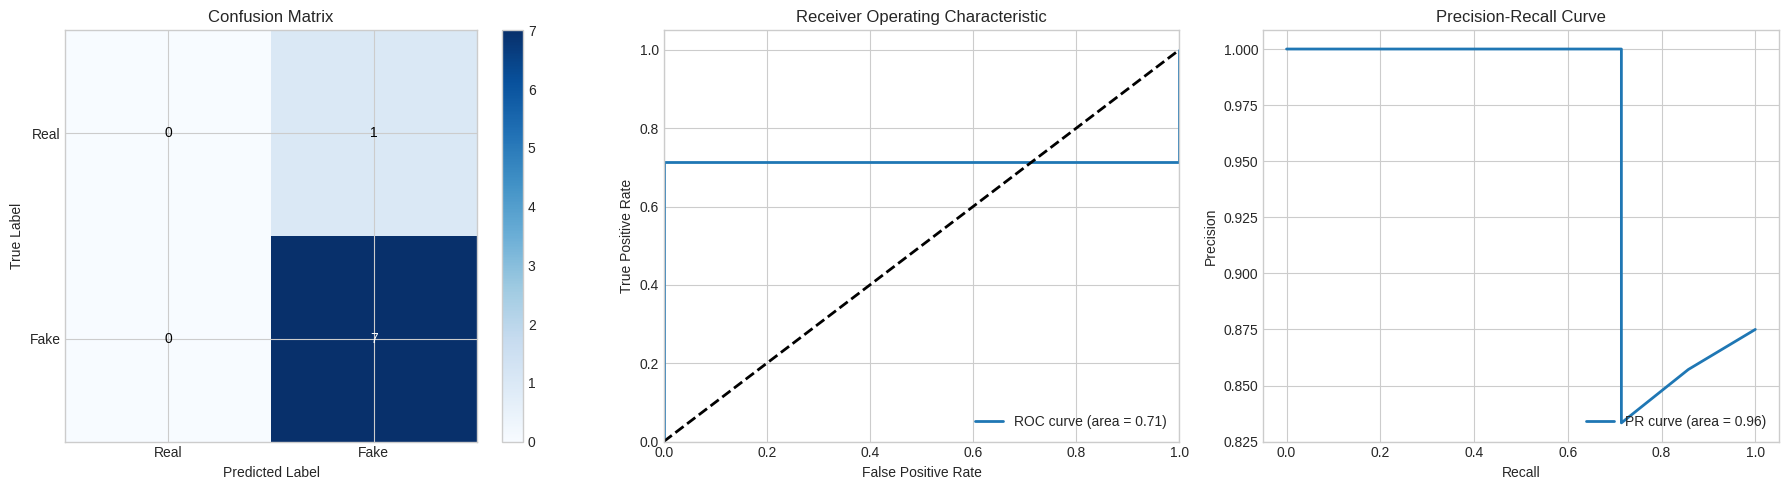

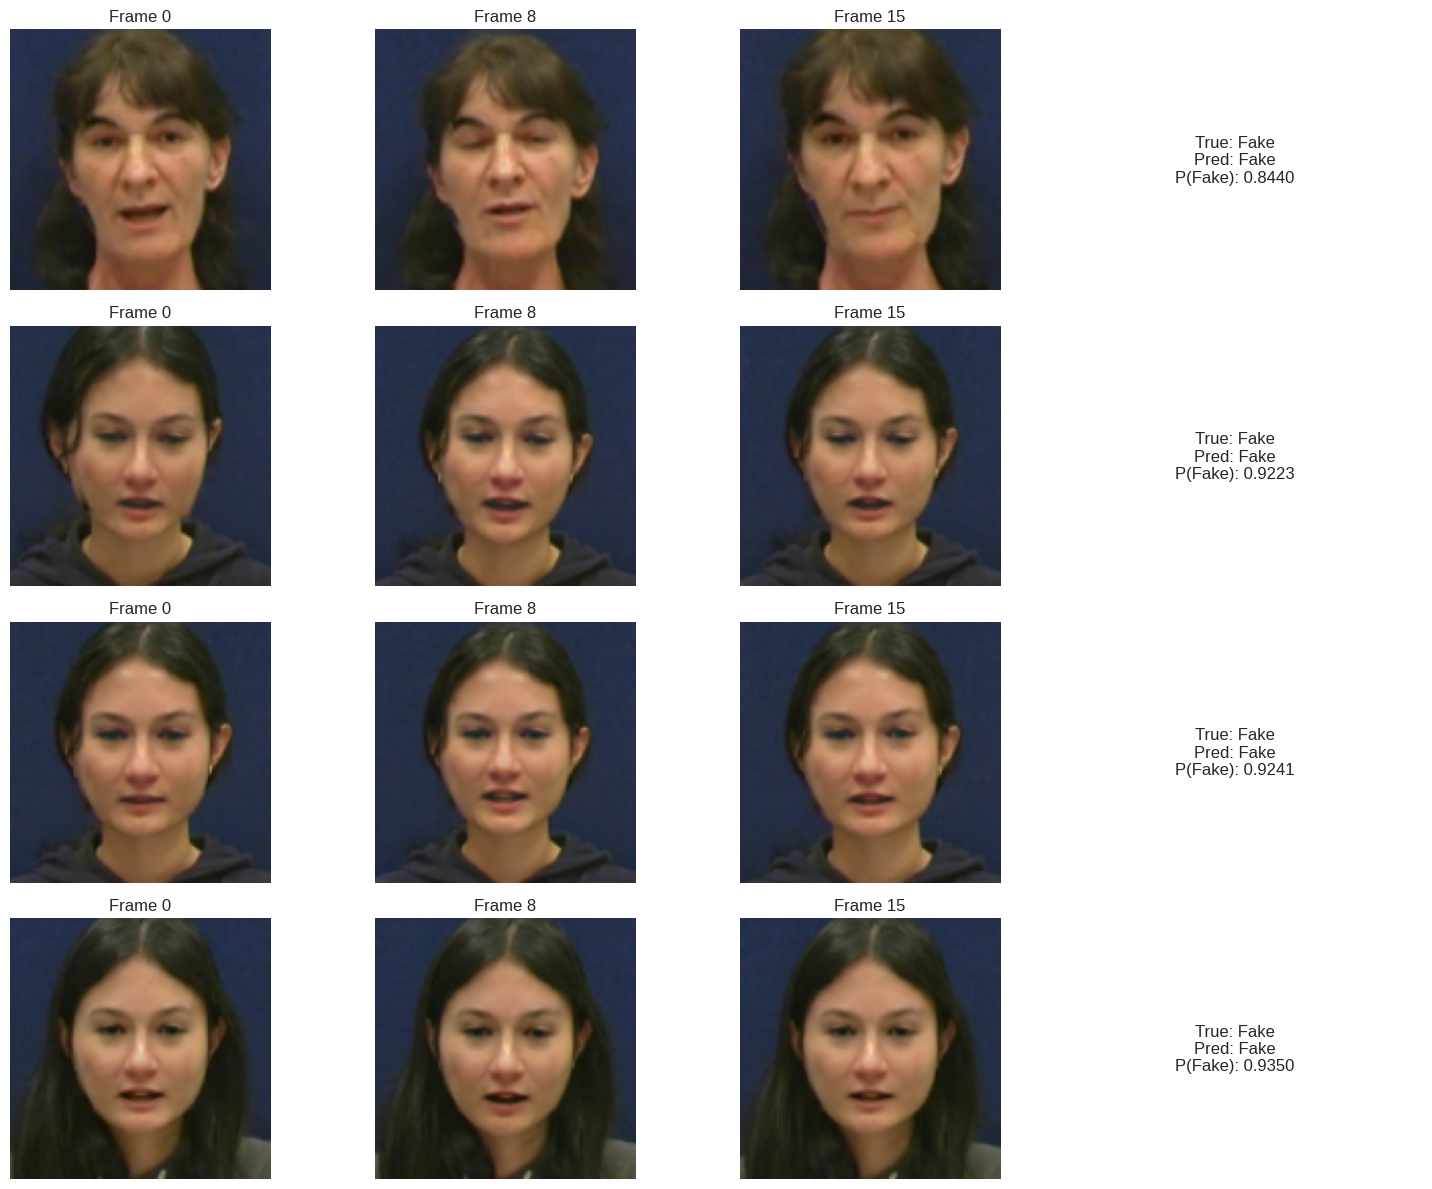


Training and evaluation complete!
Final Accuracy: 0.8750
ROC AUC: 0.7143
PR AUC: 0.9588


In [ ]:
if __name__ == "__main__":
    results = main()
    print("\nTraining and evaluation complete!")
    print(f"Final Accuracy: {results['accuracy']:.4f}")
    print(f"ROC AUC: {results['roc_auc']:.4f}")
    print(f"PR AUC: {results['pr_auc']:.4f}")

## 9. Analysis and Insights

After training and evaluating the model, we can analyze the results to understand how well our approach works for detecting deepfakes using temporal consistency.

### Key Insights:

1. **Temporal Features**: The 3D CNN architecture enables the model to capture temporal inconsistencies between frames that are often present in deepfake videos.

2. **Face Cropping**: By focusing on facial regions, we concentrate the model's attention on the most relevant areas where manipulation artifacts are likely to appear.

3. **Transfer Learning**: Using a pre-trained R3D-18 backbone helps the model learn more effectively even with limited training data.



## 10. Thesis Figures and Diagrams

This thesis includes comprehensive Mermaid diagrams that visualize the key components of our deepfake detection approach. All diagrams are available in the `Figures/` directory:

### Available Diagrams:

1. **[Workflow Diagram](./Figures/workflow_diagram.md)**
   - Complete processing pipeline from input video to classification
   - Data preprocessing and augmentation steps
   - Model inference workflow

2. **[Dataset Overview](./Figures/dataset_overview.md)**
   - DeepfakeTIMIT dataset structure and organization
   - Data distribution and statistics
   - Train/validation/test splits

3. **[Network Architecture](./Figures/network_architecture.md)**
   - 3D CNN model based on R3D-18 architecture
   - Detailed layer-by-layer breakdown
   - Feature map dimensions and temporal processing

4. **[Results Visualization](./Figures/results_visualization.md)**
   - Training curves and convergence analysis
   - Confusion matrix and performance metrics
   - ROC curves and error analysis

### Viewing the Diagrams:

- **Online**: Use [Mermaid Live Editor](https://mermaid.live/) to view and export
- **VS Code**: Install Mermaid extensions for inline preview
- **Command Line**: Use `@mermaid-js/mermaid-cli` to render to PNG/SVG

### Integration with Results:

These diagrams complement the experimental results shown above and provide visual representations of:
- **Methodology**: How temporal inconsistencies are captured
- **Architecture**: Why 3D CNNs are effective for video analysis
- **Performance**: Quantitative results and error patterns
- **Workflow**: End-to-end processing pipeline

The diagrams are designed to be publication-ready and can be included directly in academic papers, presentations, or documentation.
